In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
import os
import time as toc
import import_ipynb

os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from SpatialTemporal_Correlation_and_Convolution import STcorrelate
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from SpatialTemporal_Correlation_and_Convolution import STconvolve
os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\MB_FB_model')
%matplotlib inline

importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


## functions

In [2]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2))/s/np.sqrt(np.pi)

In [3]:
def Retina_Mechine_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*5
    xx = np.arange(-klen,klen,dx)
    KC = K(xx,sigma_dict['C'])
    KH = K(xx,sigma_dict['H'])

    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(output[i,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*output[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))*dt
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*output[i,:])*dt
        output[i+1,:] = (output[i,:]+dyj)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj)*loc_dict['H']
        
        maxpos = np.argmax(output[i+1,:])
        rpeak[i+1]= maxpos*dx
    return output, zts, rpeak

def FB_FF_1l_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1, noiseamount=0):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*3
    xx = np.arange(-klen,klen+dx,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
    plt.plot(KC)
    plt.plot(KH)
    plt.plot(KB)
    
    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(yts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*yts[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))*dt
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*yts[i,:])*dt
        dwj =(-para_dict['gramma']*wts[i,:]+para_dict['p']*(ry-para_dict['psy']*rz))*dt
        
        noise = para_dict['k']/para_dict['alpha']*np.mean(rs)*np.random.randn(len(dyj))*noiseamount
        yts[i+1,:] = (yts[i,:]+dyj+noise)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj)*loc_dict['H']
        wts[i+1,:] = (wts[i,:]+dwj)
        maxpos = np.argmax(wts[i+1,:])
        rpeak[i+1]= maxpos*dx
    return wts, zts, yts, rpeak

In [4]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [5]:
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,0) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,0) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    return np.nansum(xy*np.log2(nxy))

In [6]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [7]:
def STA(r, x, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA

In [8]:
# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

In [9]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

## Main

In [10]:
loadfiles = np.load('CKC STkernels-good parameters.npz', allow_pickle=True)
for k in loadfiles.files:
    vars()[k] = loadfiles[k][()]
#Width setting
Dynamical_range = 6*sigma_dict['H']/dx #188-16 pixels
hw = Dynamical_range*dx/22 #half bar width  #8 pixels
xlen = 2000*dx #spatial extend of simulation
tempx = np.arange(0,xlen,dx)

In [11]:
para_dict, sigma_dict

({'alpha': 40.0,
  'beta': 2.0,
  'k': 40.0,
  'phi': 5.0,
  'g': 2.0,
  'gramma': 100.0,
  'p': 100.0,
  'psy': 0.3},
 {'H': 1, 'C': 0.2, 'B': 0.2})

In [12]:
# sigma_dict = dict()
# sigma_dict['H'] = 1
# sigma_dict['C'] = sigma_dict['H']*0.75# RF size of cone cell
# dx = 0.025*sigma_dict['H']
 
# dt=0.01
# sigma_dict['tau_y'] = 0.01                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

# #Width setting
# xlen = 2000*dx #spatial extend of simulation
# hw = 0.25*sigma_dict['H']#half bar width
# tempx = np.arange(0,xlen,dx)

# para_dict = {}
# para_dict['alpha'] = 40.
# para_dict['beta'] = 2.
# para_dict['k'] = 50.
# para_dict['phi'] = 3.
# para_dict['g'] = 20.

# para_dict['g']*para_dict['k']*para_dict['phi']/para_dict['alpha']/para_dict['beta']

In [13]:
#main
Tot=100
T=np.arange(dt,Tot,dt)
# HMM ; input
Gamma=4.5
Omega =Gamma/2.12
D = 27*10**5
HMM=np.zeros(len(T))
vL =np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    HMM[i+1]=HMM[i]+vL[i]*dt
    vL[i+1]=vL[i]*(1-dt*Gamma)- Omega**2*HMM[i]*dt+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 2
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

In [14]:
LPOU_bar = np.zeros([len(T), int(xlen/dx)])
speak = (LPOU-min(LPOU))/(max(LPOU)-min(LPOU))*Dynamical_range+600
for i in range(len(T)):
    pos = speak[i]
    min_pos = max(int(pos-hw/dx), 0)
    max_pos = min(int(pos+hw/dx), int(xlen/dx))
    LPOU_bar[i,min_pos:max_pos] = 1
    
#     while min_pos <= int(xlen/dx):
#         LPOU_bar[i,min_pos:max_pos] = 1
#         pos += 4*hw/dx
#         min_pos = max(int(pos-hw/dx), 0)
#         max_pos = min(int(pos+hw/dx), int(xlen/dx))
#     pos = speak[i]-4*hw/dx
#     min_pos = max(int(pos-hw/dx), 0)
#     max_pos = min(int(pos+hw/dx), int(xlen/dx))
#     while max_pos > 0:
#         LPOU_bar[i,min_pos:max_pos] = 1
#         pos -= 4*hw/dx
#         min_pos = max(int(pos-hw/dx), 0)
#         max_pos = min(int(pos+hw/dx), int(xlen/dx))
    

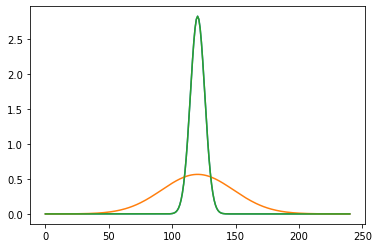

In [15]:
# LPOU_y, zts, rpeak = Retina_Mechine_1D(LPOU_bar, sigma_dict, para_dict, dx, dt)
wts, zts, yts, rpeak = FB_FF_1l_1D(LPOU_bar, sigma_dict, para_dict, dx, dt)

In [16]:
LPOU_y = wts

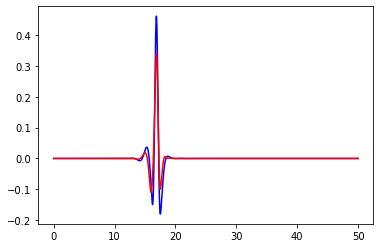

In [17]:
#####PLot numerical solution########
plt.plot(tempx,wts.T[:,-1],'b') #numerical solution
plt.plot(tempx,zts.T[:,-1],'r')    #numerical solution

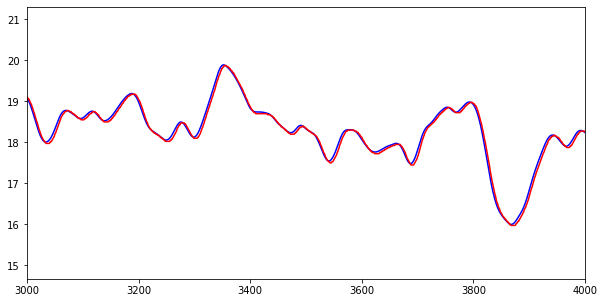

In [18]:
plt.plot(speak[10:]*dx, 'b')
plt.plot(rpeak[10:], 'r')
plt.xlim([3000,4000])
fig = plt.gcf()
fig.set_size_inches(10, 5)

In [19]:
#assign states
x = speak.copy()*dt
x = x.astype(float)
# x = (x-np.mean(x))/np.std(x)
v = ndimage.gaussian_filter1d(x.copy(), sigma=5, order=1, mode='reflect') / dt
# v = findiff.FinDiff(0, dt, acc=4)(x)
xstate, _= EqualState(x[1:], 6)
vstate, _= EqualState(v[1:], 6)
rstate, _= EqualState(rpeak[1:], 6)

In [20]:
dms = np.arange(-50,50)
mi_ss = np.array([mi_quick(speak[10:],speak[10:],d) for d in dms])
mi_sr = np.array([mi_quick(speak[10:],rpeak[10:],d) for d in dms])

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


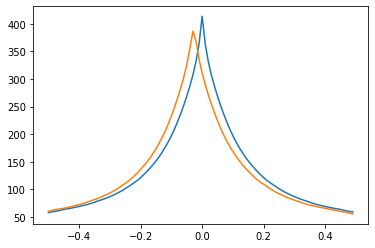

In [21]:
plt.plot(dms*dt,mi_ss/dt)
plt.plot(dms*dt,mi_sr/dt)

In [22]:
iTk = np.sum(ST_kernel, axis = 1)*dx
iSk = np.sum(ST_kernel, axis = 0)*dt
sSTk = iSk[np.newaxis,:]*iTk[:, np.newaxis]

STK_y = STconvolve(LPOU_bar,ST_kernel,dx,dt)
SeSTK_y = STconvolve(LPOU_bar,sSTk,dx,dt)

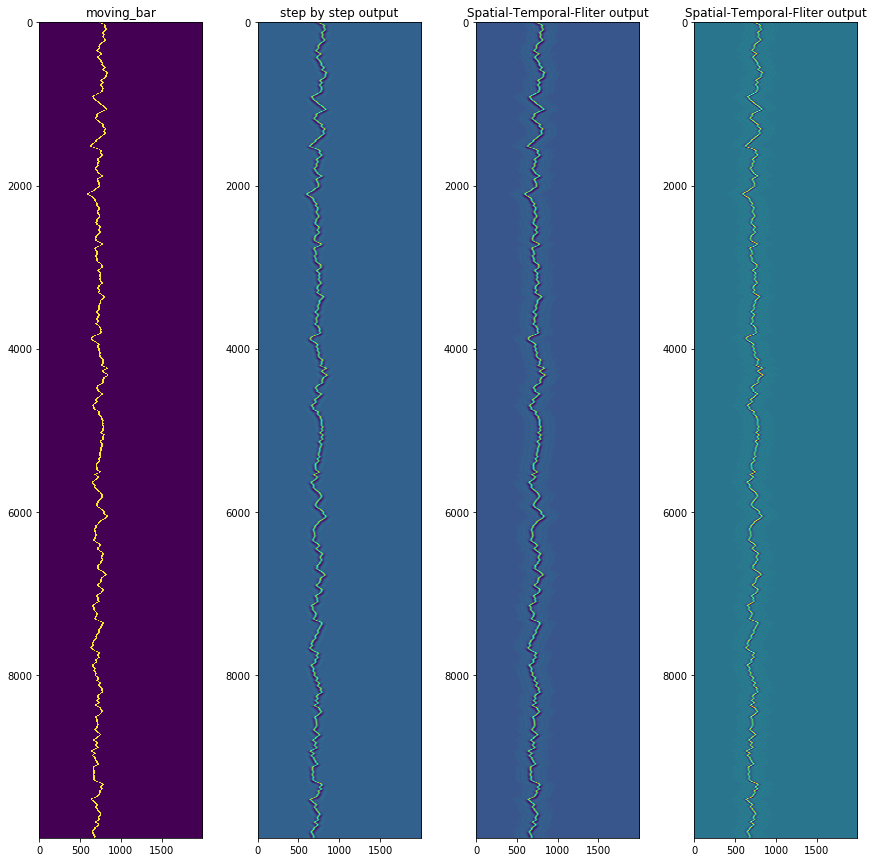

In [23]:
fig, (ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=4) 
ax2.imshow(LPOU_bar)
ax2.set_title('moving_bar')
ax3.imshow(wts)
ax3.set_title('step by step output')
ax4.imshow(STK_y)
ax4.set_title('Spatial-Temporal-Fliter output')
ax5.imshow(SeSTK_y)
ax5.set_title('Spatial-Temporal-Fliter output')
fig.set_size_inches(15, 15)

In [24]:
STrpeak = np.zeros_like(rpeak)
for i in range(STK_y.shape[0]):
    STrpeak[i] = np.argmax(STK_y[i,:])

In [25]:
STrstate, _= EqualState(STrpeak[1:], 6)

In [26]:
window = [-0.5,0.5] # second
timeshift, STK_Information = PIfunc(STrstate, xstate, vstate, dt, window)
timeshift, LPOU_Information = PIfunc(rstate, xstate, vstate, dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered i

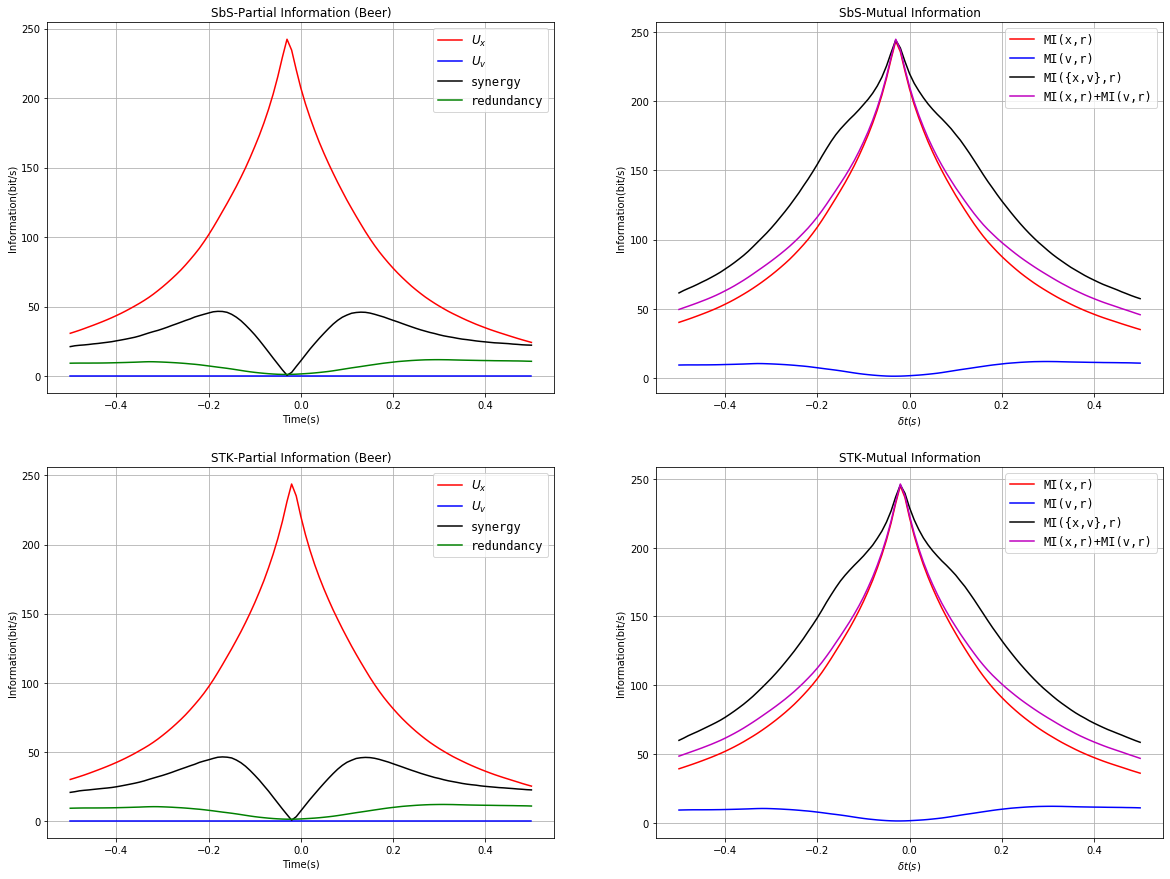

In [27]:
fig, ((ax2,ax3),(ax4,ax5)) = plt.subplots(nrows=2, ncols=2) 
ax2.plot(timeshift,LPOU_Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,LPOU_Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,LPOU_Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,LPOU_Information[('Beer','Red')], 'g-')
ax2.set_title('SbS-Partial Information (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

ax3.plot(timeshift,LPOU_Information[('Beer','UIx')]+LPOU_Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,LPOU_Information[('Beer','UIv')]+LPOU_Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,LPOU_Information[('Beer','Syn')]+LPOU_Information[('Beer','Red')]+LPOU_Information[('Beer','UIv')]+LPOU_Information[('Beer','UIx')], 'k-')
ax3.plot(timeshift,2*LPOU_Information[('Beer','Red')]+LPOU_Information[('Beer','UIv')]+LPOU_Information[('Beer','UIx')], 'm-')
ax3.set_title('SbS-Mutual Information')
ax3.set_xlabel(r'$\delta t(s)$')
ax3.set_ylabel('Information(bit/s)')
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()

ax4.plot(timeshift,STK_Information[('Beer','UIx')], 'r-')
ax4.plot(timeshift,STK_Information[('Beer','UIv')], 'b-')
ax4.plot(timeshift,STK_Information[('Beer','Syn')], 'k-')
ax4.plot(timeshift,STK_Information[('Beer','Red')], 'g-')
ax4.set_title('STK-Partial Information (Beer)')
ax4.set_xlabel('Time(s)')
ax4.set_ylabel('Information(bit/s)')
ax4.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax4.grid()

ax5.plot(timeshift,STK_Information[('Beer','UIx')]+STK_Information[('Beer','Red')], 'r-')
ax5.plot(timeshift,STK_Information[('Beer','UIv')]+STK_Information[('Beer','Red')], 'b-')
ax5.plot(timeshift,STK_Information[('Beer','Syn')]+STK_Information[('Beer','Red')]+STK_Information[('Beer','UIv')]+STK_Information[('Beer','UIx')], 'k-')
ax5.plot(timeshift,2*STK_Information[('Beer','Red')]+STK_Information[('Beer','UIv')]+STK_Information[('Beer','UIx')], 'm-')
ax5.set_title('STK-Mutual Information')
ax5.set_xlabel(r'$\delta t(s)$')
ax5.set_ylabel('Information(bit/s)')
ax5.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax5.grid()

fig.set_size_inches(20, 15)

In [28]:
# activation function
def nA(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= 1
    return(y)

# activation function
def nA2(x,theta1, theta2):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta2>0:
            y[i]= 2
        elif x[i]- theta1>0:
            y[i]= 1
    return(y)

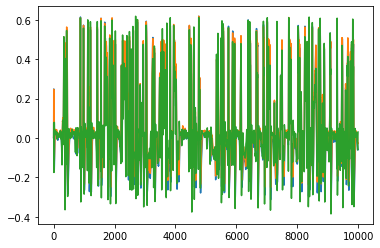

In [29]:
Sindex = 600+int(Dynamical_range/2)
LPOU_yy = np.zeros(LPOU_y.shape[0])
STK_yy = np.zeros(LPOU_y.shape[0])
SeSTK_yy = np.zeros(LPOU_y.shape[0])
ratio = np.max(LPOU_y[:,Sindex])/np.max(STK_y[:,Sindex])
ratio2 = np.max(LPOU_y[:,Sindex])/np.max(SeSTK_y[:,Sindex])
for i in range( LPOU_y.shape[0]):
    LPOU_yy[i] = LPOU_y[i][Sindex]
    STK_yy[i] = STK_y[i][Sindex]*ratio
    SeSTK_yy[i] = SeSTK_y[i][Sindex]*ratio2
plt.plot(LPOU_yy)
plt.plot(STK_yy)
plt.plot(SeSTK_yy)

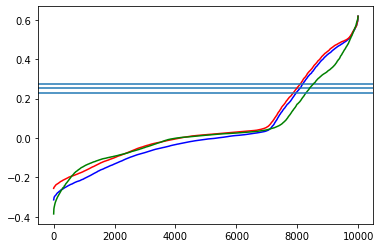

In [30]:
fig, ax = plt.subplots()
ax.plot(np.sort(LPOU_yy),'b')
ax.axhline(1.0*np.std(LPOU_yy)+np.mean(LPOU_yy))
ax.plot(np.sort(STK_yy),'r')
ax.axhline(1.0*np.std(STK_yy)+np.mean(STK_yy))
ax.plot(np.sort(SeSTK_yy),'g')
ax.axhline(1.0*np.std(SeSTK_yy)+np.mean(SeSTK_yy))

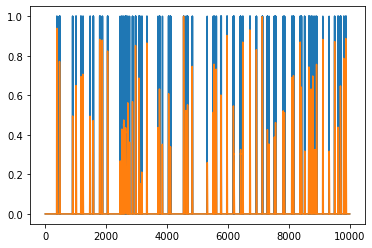

In [40]:
r = NL(np.mean(LPOU_yy)-LPOU_yy, 1.0*np.std(LPOU_yy))
# r = NL(yyy, 0)
# # r = yyy-np.min(yyy)
ratio = sum(r)/Tot/3
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
rstate,_  = np.histogram(FakeSpike, np.append(0,T))
plt.plot(rstate)
plt.plot(r/max(r))
LPOU_yyrstate = rstate.copy()

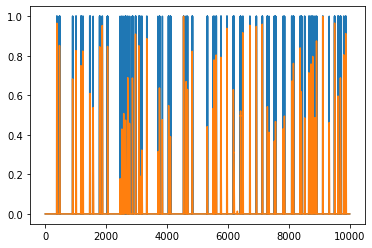

In [41]:
r = NL(np.mean(STK_yy)-STK_yy, 1.0*np.std(STK_yy))
# r = NL(yyy, 0)
# # r = yyy-np.min(yyy)
ratio = sum(r)/Tot/3
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
rstate,_  = np.histogram(FakeSpike, np.append(0,T))
plt.plot(rstate)
plt.plot(r/max(r))
STK_yyrstate = rstate.copy()

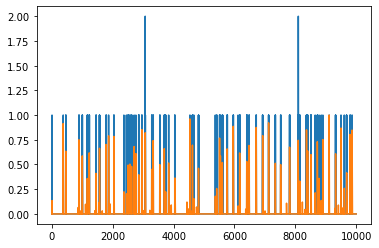

In [42]:
r = NL(np.mean(SeSTK_yy)-SeSTK_yy, 1.0*np.std(SeSTK_yy))
# r = NL(yyy, 0)
# # r = yyy-np.min(yyy)
ratio = sum(r)/Tot/3
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
rstate,_  = np.histogram(FakeSpike, np.append(0,T))
plt.plot(rstate)
plt.plot(r/max(r))
SeSTK_yyrstate = rstate.copy()

In [43]:
# yyrstate, _= EqualState(yy, 6)
# LPOU_yyrstate = nA2(LPOU_yy, theta1, theta2)
# STK_yyrstate = nA2(STK_yy, theta1, theta2)
window = [-1,1] # second
timeshift, LPOU_Information = PIfunc(LPOU_yyrstate[1:], xstate, vstate, dt, window)
timeshift, STK_Information = PIfunc(SeSTK_yyrstate[1:], xstate, vstate, dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered i

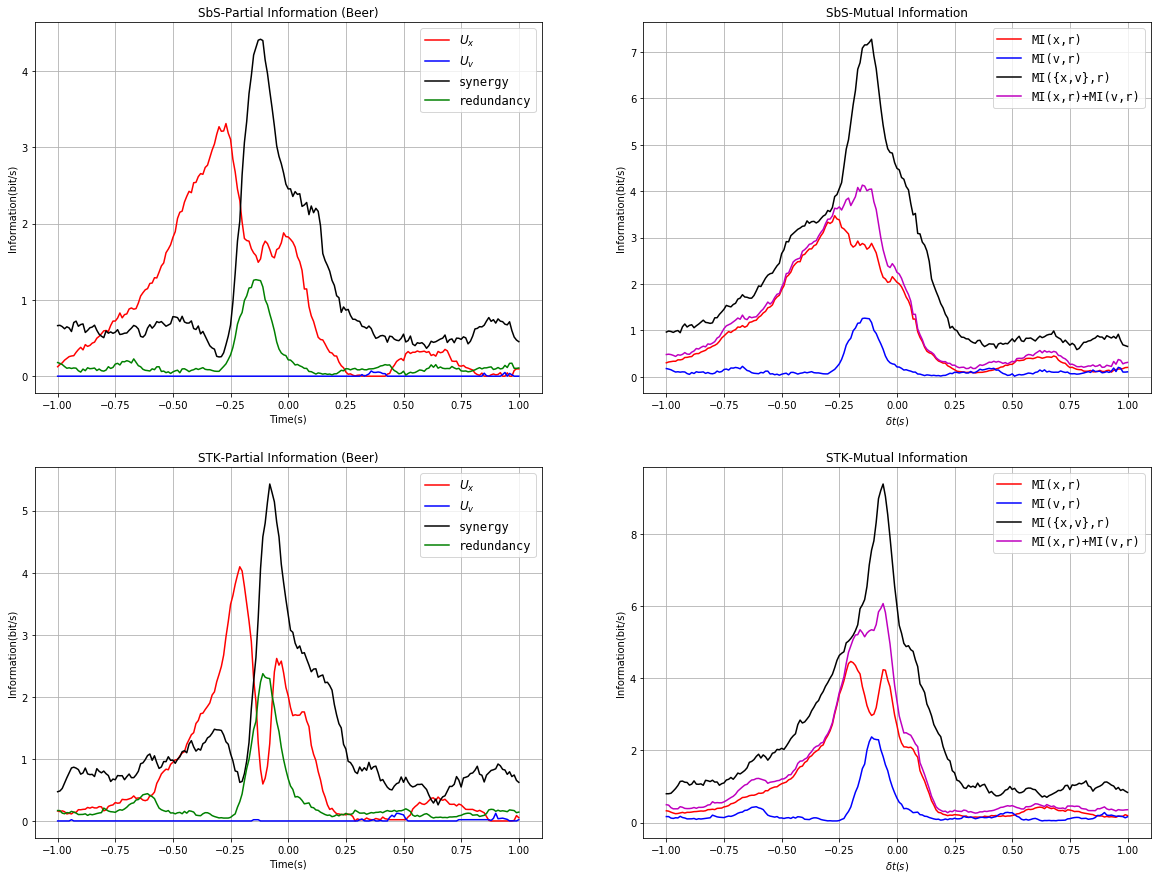

In [44]:
fig, ((ax2,ax3),(ax4,ax5)) = plt.subplots(nrows=2, ncols=2) 
ax2.plot(timeshift,LPOU_Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,LPOU_Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,LPOU_Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,LPOU_Information[('Beer','Red')], 'g-')
ax2.set_title('SbS-Partial Information (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

ax3.plot(timeshift,LPOU_Information[('Beer','UIx')]+LPOU_Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,LPOU_Information[('Beer','UIv')]+LPOU_Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,LPOU_Information[('Beer','Syn')]+LPOU_Information[('Beer','Red')]+LPOU_Information[('Beer','UIv')]+LPOU_Information[('Beer','UIx')], 'k-')
ax3.plot(timeshift,2*LPOU_Information[('Beer','Red')]+LPOU_Information[('Beer','UIv')]+LPOU_Information[('Beer','UIx')], 'm-')
ax3.set_title('SbS-Mutual Information')
ax3.set_xlabel(r'$\delta t(s)$')
ax3.set_ylabel('Information(bit/s)')
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()

ax4.plot(timeshift,STK_Information[('Beer','UIx')], 'r-')
ax4.plot(timeshift,STK_Information[('Beer','UIv')], 'b-')
ax4.plot(timeshift,STK_Information[('Beer','Syn')], 'k-')
ax4.plot(timeshift,STK_Information[('Beer','Red')], 'g-')
ax4.set_title('STK-Partial Information (Beer)')
ax4.set_xlabel('Time(s)')
ax4.set_ylabel('Information(bit/s)')
ax4.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax4.grid()

ax5.plot(timeshift,STK_Information[('Beer','UIx')]+STK_Information[('Beer','Red')], 'r-')
ax5.plot(timeshift,STK_Information[('Beer','UIv')]+STK_Information[('Beer','Red')], 'b-')
ax5.plot(timeshift,STK_Information[('Beer','Syn')]+STK_Information[('Beer','Red')]+STK_Information[('Beer','UIv')]+STK_Information[('Beer','UIx')], 'k-')
ax5.plot(timeshift,2*STK_Information[('Beer','Red')]+STK_Information[('Beer','UIv')]+STK_Information[('Beer','UIx')], 'm-')
ax5.set_title('STK-Mutual Information')
ax5.set_xlabel(r'$\delta t(s)$')
ax5.set_ylabel('Information(bit/s)')
ax5.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax5.grid()

fig.set_size_inches(20, 15)